In [84]:
from pyomo.environ import Var, Expression, NonNegativeReals, Block, ConcreteModel, Constraint, Objective, Param, maximize, SolverFactory,RangeSet
import pyomo.environ as pyo
from idaes.core import FlowsheetBlock
import numpy as np
from pyomo.util.infeasible import log_infeasible_constraints, log_infeasible_bounds

In [72]:
# bw_vol = np.array([[0.05], [0.06]])
bw_vol = np.array([0.05, 0.06])
# bw_vol = bw_vol.T
dist =  np.array([[200,400,100],
                 [150,250,50]])

LCOW = np.array([0.2,0.1])

def transport_cost(bw_vol,dist):
    cost1 = (0.2 + 0.02*dist)*bw_vol
    cost2 = 0.02*dist
    return float(min(cost1,cost2))

demand = np.array([0.5,0.3,0.1])
# Assuming 3 demand sites
# Maximum supply possible
max_supply = sum(bw_vol)/3

print(bw_vol)
print(max_supply)


[0.05 0.06]
0.03666666666666667


In [64]:
def update_demand(supply_max,demand):
    for i in range(0,len(demand)):
        if demand[i]>supply_max:
            demand[i]=supply_max
    return demand

print(demand)
demand_new = update_demand(max_supply,demand)


print(demand_new)

[0.5 0.3 0.1]
[0.03666667 0.03666667 0.03666667]


In [86]:
# Adding constraint for supply

# Trying to add powerplant as another index along with brackish water

m = ConcreteModel()

# transport_cost = 0.01
# demand = np.array([1,0.3,0.1])
# transport_coeff = bw_vol*dist*transport_cost(bw_vol,dist)

# brackish water site index
m.I = pyo.Set(initialize = range(dist.shape[0]))
# powerplant site index
m.J = pyo.Set(initialize = range(dist.shape[1]))

m.matrix= pyo.Set(initialize = m.I*m.J)
m.x = Var(m.matrix, domain=NonNegativeReals, bounds= (0,1))

m.constraints= pyo.ConstraintList()

# Sum of fractions should be less than or equal to 1
for i in m.I:
    m.constraints.add((sum(m.x[i,j]*float(bw_vol[i])for j in m.J)) == float(bw_vol[i]))

# Production to be as close to maximum as possible
for j in m.J:
    m.constraints.add((sum(m.x[i,j]*float(bw_vol[i]) for i in m.I)) >= demand_new[j])
    # m.constraints.add((sum(m.x[i,j]*float(bw_vol[i]) for i in m.I)) >= demand[j])

# LCOW objective
def obj_LCOW(m):
    return sum(sum((LCOW[i]*m.x[i,j] + transport_cost(bw_vol[i],dist[i,j])*m.x[i,j]) for i in m.I) for j in m.J)


m.obj1 = Objective(rule = obj_LCOW)
solver = SolverFactory('ipopt')
results = solver.solve(m)

m.display()

Model unknown

  Variables:
    x : Size=6, Index=matrix
        Key    : Lower : Value                 : Upper : Fixed : Stale : Domain
        (0, 0) :     0 :   0.49999979889272667 :     1 : False : False : NonNegativeReals
        (0, 1) :     0 : 1.505903749978982e-08 :     1 : False : False : NonNegativeReals
        (0, 2) :     0 :    0.5000001860482358 :     1 : False : False : NonNegativeReals
        (1, 0) :     0 :   0.19444446182919078 :     1 : False : False : NonNegativeReals
        (1, 1) :     0 :    0.6111109421232765 :     1 : False : False : NonNegativeReals
        (1, 2) :     0 :   0.19444459604753095 :     1 : False : False : NonNegativeReals

  Objectives:
    obj1 : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : 0.701999945936073

  Constraints:
    constraints : Size=5
        Key : Lower               : Body                 : Upper
          1 :                0.05 :                 0.05 :  0.05
          2 :         

In [85]:
for c in m.component_objects(ctype=Constraint):
    if c.slack() < 0:  # constraint is not met
        c.pprint()

AttributeError: 'ConstraintList' object has no attribute 'slack'

In [39]:
# Trying to add powerplant as another index along with brackish water

m = ConcreteModel()

# transport_cost = 0.01
# demand = np.array([1,0.3,0.1])
# transport_coeff = bw_vol*dist*transport_cost(bw_vol,dist)

# brackish water site index
m.I = pyo.Set(initialize = range(dist.shape[0]))
# powerplant site index
m.J = pyo.Set(initialize = range(dist.shape[1]))

m.matrix= pyo.Set(initialize = m.I*m.J)
m.x = Var(m.matrix, domain=NonNegativeReals, bounds= (0,1))

m.constraints= pyo.ConstraintList()

# Sum of fractions should be less than or equal to 1
for i in m.I:
    m.constraints.add((sum(m.x[i,j] for j in m.J)) <= 1)

# Production to be as close to maximum as possible
for j in m.J:
    m.constraints.add((sum(m.x[i,j]*float(bw_vol[i]) for i in m.I)) >= demand_new[j])

# for j in m.J:
#     m.constraints.add((sum(( LCOW[i]*m.x[i,j] + transport_cost(bw_vol[i],dist[i,j])*m.x[i,j] ) for i in m.I)) <= 1.4)

def obj_demand(m):
    return sum(sum(m.x[i,j]*float(bw_vol[i]) for i in m.I) for j in m.J)

m.f2 = Var()
m.C_demand = Constraint(expr = m.f2 == sum(sum(m.x[i,j]*float(bw_vol[i]) for i in m.I) for j in m.J))

# LCOW objective
def obj_LCOW(m):
    return sum(sum((LCOW[i]*m.x[i,j] + transport_cost(bw_vol[i],dist[i,j])*m.x[i,j]) for i in m.I) for j in m.J)

m.f1 = Var()
m.C_LCOW =  Constraint(expr = m.f1 == sum(sum((LCOW[i]*m.x[i,j] + transport_cost(bw_vol[i],dist[i,j])*m.x[i,j]) for i in m.I) for j in m.J) )
# m.obj1 = Objective(rule = obj_LCOW)
# solver = SolverFactory('ipopt')
# results = solver.solve(m)

# trying multiobjective
m.obj2 = Objective(rule = obj_demand, sense = maximize)
m.obj1 = Objective(rule = obj_LCOW)

m.obj2.deactivate()

solver = SolverFactory('ipopt')
results = solver.solve(m)

f2_min = pyo.value(m.f2)

lcow_min = pyo.value(m.f2)

m.obj1.deactivate()
m.obj2.activate()

solver = SolverFactory('ipopt')
results = solver.solve(m)

f2_max = pyo.value(m.f2)

m.obj1.activate()
m.obj2.deactivate()

m.e = Param(initialize=0, mutable=True)

m.C_epsilon = Constraint(expr = m.f2 == m.e)
solver.solve(m)

# print(f2_min)
# print(f2_max)

# n = 4
# step = int(((f2_max - f2_min)*1000)/ n)
# print(step)
# steps = list(range(int(f2_min),int(f2_max),step)/100) + [f2_max]
# print(steps)

# x1_l = []
# x2_l = []
# for i in steps:
#     m.e = i
#     solver.solve(m)
#     # x1_l.append(pyo.value(m.X1))
    # x2_l.append(pyo.value(m.X2))
# plt.plot(x1_l,x2_l,'o-.')
# plt.title('inefficient Pareto-front')
# plt.grid(True)




m.display()

    model=unknown;
        message from solver=Ipopt 3.13.2\x3a Converged to a locally infeasible
        point. Problem may be infeasible.
Model unknown

  Variables:
    x : Size=6, Index=matrix
        Key    : Lower : Value               : Upper : Fixed : Stale : Domain
        (0, 0) :     0 : 0.19318353519384962 :     1 : False : False : NonNegativeReals
        (0, 1) :     0 : 0.19621955951418388 :     1 : False : False : NonNegativeReals
        (0, 2) :     0 : 0.19224689005788184 :     1 : False : False : NonNegativeReals
        (1, 0) :     0 : 0.18401745267320052 :     1 : False : False : NonNegativeReals
        (1, 1) :     0 :  0.1896809713469862 :     1 : False : False : NonNegativeReals
        (1, 2) :     0 :  0.1834736152724547 :     1 : False : False : NonNegativeReals
    f2 : Size=1, Index=None
        Key  : Lower : Value               : Upper : Fixed : Stale : Domain
        None :  None : 0.03108361026040684 :  None : False : False :  Reals
    f1 : Size=1, 

In [5]:
dict = (m.x.get_values())

# print(dict[(0,0)])
x = np.zeros(dist.shape)
# print(x)
for i,j in dict.keys():
    x[i,j] = dict[(i,j)]

x=np.array(x)
print(x)

[[4.99999702e-01 1.50590375e-08 4.99999703e-01]
 [1.94444531e-01 6.11110936e-01 1.94444532e-01]]


In [6]:
# check supply to each demand point

demand1 = bw_vol.T*x[:,0].T
demand2 = bw_vol.T*x[:,1].T
demand3 = bw_vol.T*x[:,2].T

print(x[:,0])
print(bw_vol)

print(sum(demand1))



[0.4999997  0.19444453]
[0.05 0.06]
0.03666665698581465


( X1 , X2 ) = ( 20.00000019749421 , 2.306529126987906 )
f1 = 20.00000019749421
f2 = 69.22611710043425
( X1 , X2 ) = ( 8.000000080417626 , 40.00000039843382 )
f1 = 8.000000080417626
f2 = 184.00000183498815
Each iteration will keep f2 lower than some values between f2_min and f2_max, so [69.22611710043425, 184.00000183498815]


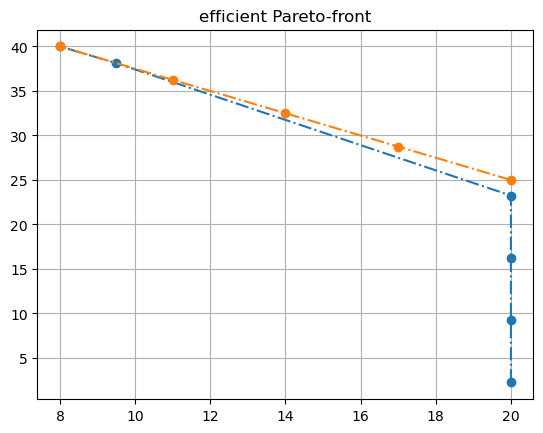

In [7]:
from pyomo.environ import *
import matplotlib.pyplot as plt


# max f1 = X1 <br>
# max f2 = 3 X1 + 4 X2 <br>
# st  X1 <= 20 <br>
#     X2 <= 40 <br>
#     5 X1 + 4 X2 <= 200 <br>

model = ConcreteModel()

model.X1 = Var(within=NonNegativeReals)
model.X2 = Var(within=NonNegativeReals)

model.C1 = Constraint(expr = model.X1 <= 20)
model.C2 = Constraint(expr = model.X2 <= 40)
model.C3 = Constraint(expr = 5 * model.X1 + 4 * model.X2 <= 200)

model.f1 = Var()
model.f2 = Var()
model.C_f1 = Constraint(expr= model.f1 == model.X1)
model.C_f2 = Constraint(expr= model.f2 == 3 * model.X1 + 4 * model.X2)
model.O_f1 = Objective(expr= model.f1  , sense=maximize)
model.O_f2 = Objective(expr= model.f2  , sense=maximize)

model.O_f2.deactivate()

solver = SolverFactory('ipopt')
solver.solve(model)

print( '( X1 , X2 ) = ( ' + str(value(model.X1)) + ' , ' + str(value(model.X2)) + ' )')
print( 'f1 = ' + str(value(model.f1)) )
print( 'f2 = ' + str(value(model.f2)) )
f2_min = value(model.f2)


# ## max f2

model.O_f2.activate()
model.O_f1.deactivate()

solver = SolverFactory('ipopt')
solver.solve(model)

print( '( X1 , X2 ) = ( ' + str(value(model.X1)) + ' , ' + str(value(model.X2)) + ' )')
print( 'f1 = ' + str(value(model.f1)) )
print( 'f2 = ' + str(value(model.f2)) )
f2_max = value(model.f2)


# ## apply normal $\epsilon$-Constraint

model.O_f1.activate()
model.O_f2.deactivate()

model.e = Param(initialize=0, mutable=True)

model.C_epsilon = Constraint(expr = model.f2 == model.e)

solver.solve(model)

print('Each iteration will keep f2 lower than some values between f2_min and f2_max, so ['       + str(f2_min) + ', ' + str(f2_max) + ']')

n = 4
step = int((f2_max - f2_min) / n)
steps = list(range(int(f2_min),int(f2_max),step)) + [f2_max]

x1_l = []
x2_l = []
for i in steps:
    model.e = i
    solver.solve(model)
    x1_l.append(value(model.X1))
    x2_l.append(value(model.X2))
plt.plot(x1_l,x2_l,'o-.')
plt.title('inefficient Pareto-front')
plt.grid(True)


# ## apply augmented $\epsilon$-Constraint

# max   f2 + delta*epsilon <br>
#  s.t. f2 - s = e

model.del_component(model.O_f1)
model.del_component(model.O_f2)
model.del_component(model.C_epsilon)

model.delta = Param(initialize=0.00001)

model.s = Var(within=NonNegativeReals)

model.O_f1 = Objective(expr = model.f1 + model.delta * model.s, sense=maximize)

model.C_e = Constraint(expr = model.f2 - model.s == model.e)

x1_l = []
x2_l = []
for i in range(160,190,6):
    model.e = i
    solver.solve(model)
    x1_l.append(value(model.X1))
    x2_l.append(value(model.X2))
plt.plot(x1_l,x2_l,'o-.')
plt.title('efficient Pareto-front')
plt.grid(True)